# Example 1: 2D LOWFS Estimates in tip-tilt

This example shows how to use lowfssim to model the 2D response of LOWFS to tip and tilt.  It showcases:

- the basic mechanics of setting up a modeling session and building an estimator
- using that estimator to pose and answer a large-scale modeling question

Because the grid is on a 1 mas pitch over a wide range of +/- 150 mas, there are 301x301x9 wavelengths = 815,409 forward model invocations in this example.  With lowfssim this takes about 20 minutes on a commodity GPU, which is an unbothersome amount of time.  The resolution can be lowered to 31x31 by using a 10 mas pitch to obtain an image of nearly the same smoothness while reducing the computation time by 100x for lower power hardware such as an ultralight laptop.

In [15]:
# this import block isn't any of the good stuff

from pathlib import Path

from lowfsc import props
from lowfsc.data import DesignData
from lowfsc.spectral import StellarDatabase, ThroughputDatabase, LOWFS_BANDPASS
from lowfsc.reconstruction import Reconstructor, synthesize_pupil_shear, prepare_Zmm
from lowfsc.automate import chop_bipolar

from tqdm import tqdm

from prysm.conf import config
from prysm.fttools import mdft

import cupy as cp
from cupyx.scipy import fft as cpfft

from prysm.mathops import np, fft

from matplotlib import pyplot as plt

mdft.clear()
fft._srcmodule = cpfft
np._srcmodule = cp
config.precision = 32

plt.style.use('bmh')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
root = Path('~/src/lowfssim-public/data').expanduser()

# there won't be a camera model used here
star_type1 = 'g0v'
wvl = LOWFS_BANDPASS

mode='hlc' # or spec or wfov
dd = DesignData.hlc_design(root)
sd = StellarDatabase.bijan_data(root)
td = ThroughputDatabase.bijan_data(root)

throughput = td(mode, wvl)

weights = sd(star_type1, wvl)
fudge = sd.sparsity_fudge_factor(star_type1, wvl)

# magnitude 2.25 star, but meaningless without camera model
v = 10 ** (-2.25/2.5)
weights = weights * (fudge*v*throughput)
dd.seed_zernikes(range(2,12))
wt = np.zeros(10)

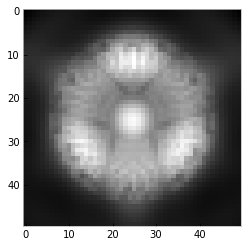

In [37]:
CHOPSIZE = 5
# this is a "more clever" way of doing the same thing as the lowfssim manual
chops = np.diag(np.ones_like(wt)*CHOPSIZE)
ref_z = np.zeros_like(wt)

# chop_bipolar permits cross terms in the chopping for a more general modeling capability and doesn't
# know that the chops input is diagonal, we have to do that part ourselves
# the scaling just makes the units of the estimator into nanometers
diffs, ups, downs = chop_bipolar(wvl, weights, dd, ref_z, chops)
for diff in diffs:
    diff /= CHOPSIZE
    
ref = props.polychromatic(wvl, weights, dd, ref_z)
chop_shear_px = 0.038
sy = synthesize_pupil_shear(ref, chop_shear_px, 0)
sx = synthesize_pupil_shear(ref, chop_shear_px, 1)
sy /= chop_shear_px
sx /= chop_shear_px
mask = np.ones_like(ref)
mask[0,:] = 0
mask[-1,:] = 0
mask[:,0] = 0
mask[:,-1] = 0

zmm = prepare_Zmm(diffs, ref, (sx,sy), mask)
R = Reconstructor(zmm, ref)
plt.imshow(ref.get(), cmap='gray')
plt.grid(False)

In [34]:
# check that the estimator is well formed.  It should see about CHOPSIZE
# for any of the up chops
R.estimate(ups[0])[1]

array(5.003017, dtype=float32)

In [42]:
mas2nm = 2.87
scan_mas = np.arange(-150,151).get() # arange excludes endpoint
estimates = np.empty((scan_mas.size,scan_mas.size,17), dtype=ref.dtype)
wt_work = wt.copy()
# tqdm s/it for 301x9 model invocations at once, 'per-row of image'; 3.9s/it ~= 1.4ms/model
for i, ptY in enumerate(tqdm(scan_mas)):
    for j, ptX in enumerate(scan_mas):
        wt_work[:] = 0
        wt_work[0] = ptX * mas2nm
        wt_work[1] = ptY * mas2nm
        im = props.polychromatic(wvl, weights, dd, wt_work)
        est = R.estimate(im)
        estimates[i,j,:] = est

100%|██████████| 301/301 [19:44<00:00,  3.94s/it]


[Text(0.5, 0, 'Input Z2, mas ots'),
 Text(0, 0.5, 'Input Z3, mas ots'),
 Text(0.5, 1.0, '2D LOWFS Response to Z2')]

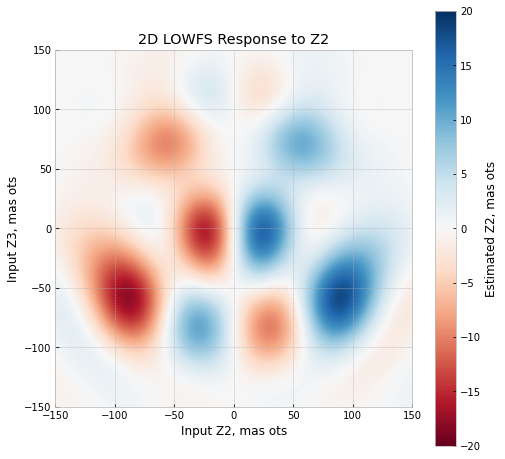

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
imc = ax.imshow(estimates[...,1].get()/mas2nm,
                extent=[-150,150,-150,150],
                interpolation='lanczos',
                cmap='RdBu', clim=(-20,20))
plt.colorbar(imc, label='Estimated Z2, mas ots')
ax.set(xlabel='Input Z2, mas ots', ylabel='Input Z3, mas ots', title='2D LOWFS Response to Z2')

[Text(0.5, 0, 'Input Z2, mas ots'),
 Text(0, 0.5, 'Input Z3, mas ots'),
 Text(0.5, 1.0, '2D LOWFS Response to Z3')]

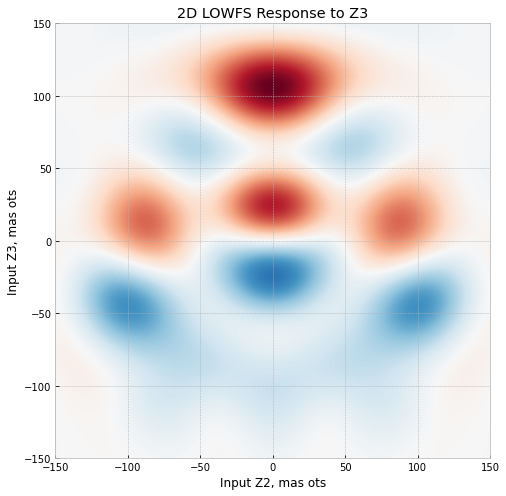

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
imc = ax.imshow(estimates[...,2].get()/mas2nm,
                extent=[-150,150,-150,150],
                interpolation='lanczos',
                cmap='RdBu', clim=(-20,20))
ax.set(xlabel='Input Z2, mas ots', ylabel='Input Z3, mas ots', title='2D LOWFS Response to Z3')